In [151]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pylab 
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import os
from sklearn.compose import ColumnTransformer

# **Data Cleaning**

In [152]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [153]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [154]:
df1 = train[train.isna().any(axis=1)]
df1.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
198,199,1,3,"Madigan, Miss. Margaret ""Maggie""",female,NaN,0,0,370370,7.7500,NaN,Q
335,336,0,3,"Denkoff, Mr. Mitto",male,NaN,0,0,349225,7.8958,NaN,S
623,624,0,3,"Hansen, Mr. Henry Damsgaard",male,21.0,0,0,350029,7.8542,NaN,S
589,590,0,3,"Murdlin, Mr. Joseph",male,NaN,0,0,A./5. 3235,8.0500,NaN,S
530,531,1,2,"Quick, Miss. Phyllis May",female,2.0,1,1,26360,26.0000,NaN,S
99,100,0,2,"Kantor, Mr. Sinai",male,34.0,1,0,244367,26.0000,NaN,S
308,309,0,2,"Abelson, Mr. Samuel",male,30.0,1,0,P/PP 3381,24.0000,NaN,C
848,849,0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.0000,NaN,S
770,771,0,3,"Lievens, Mr. Rene Aime",male,24.0,0,0,345781,9.5000,NaN,S


C:\Users\Ian\AppData\Local\Temp/ipykernel_17804/324537713.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train.hist(ax = axes)


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

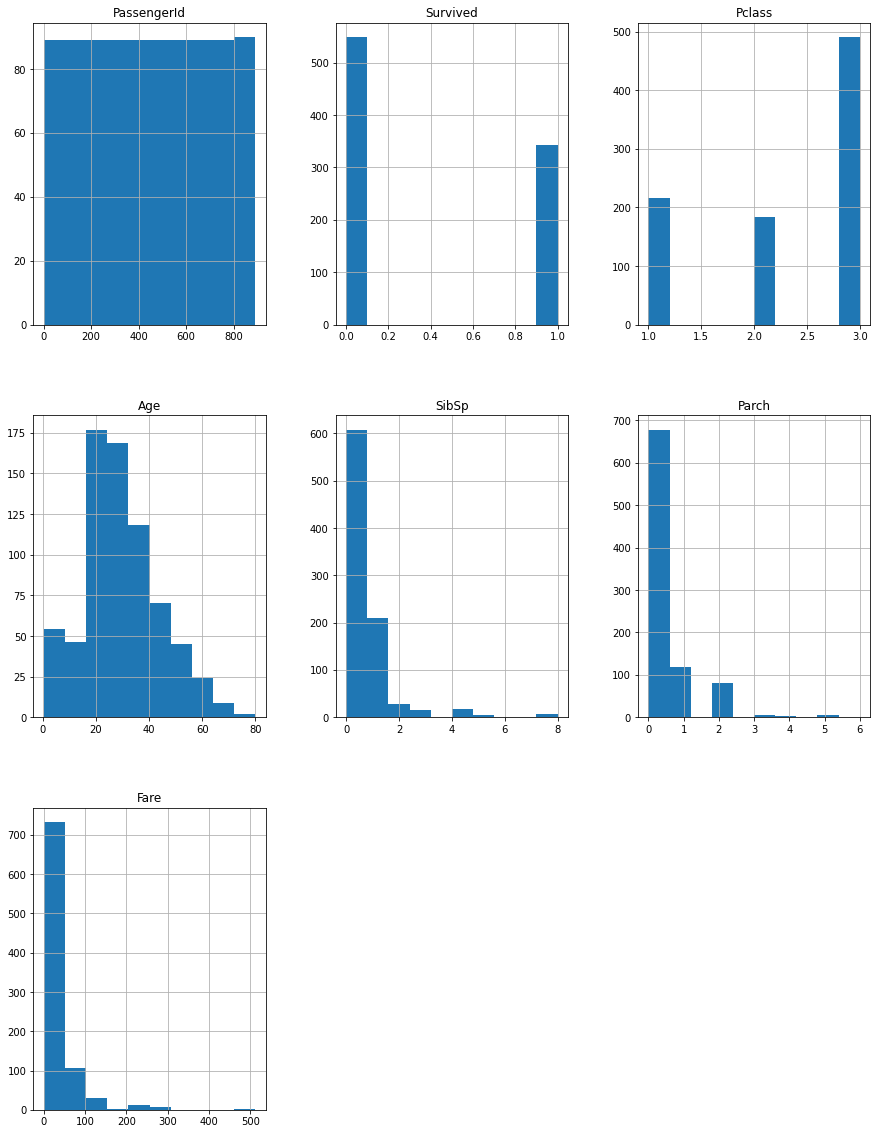

In [155]:
# distribution of each of the variables
fig = plt.figure(figsize=(15, 20))
axes = fig.gca()
train.hist(ax = axes)

**Invalid Data**

In [156]:
#deep copy of training dataset
clean_train = train.copy()

<AxesSubplot:>

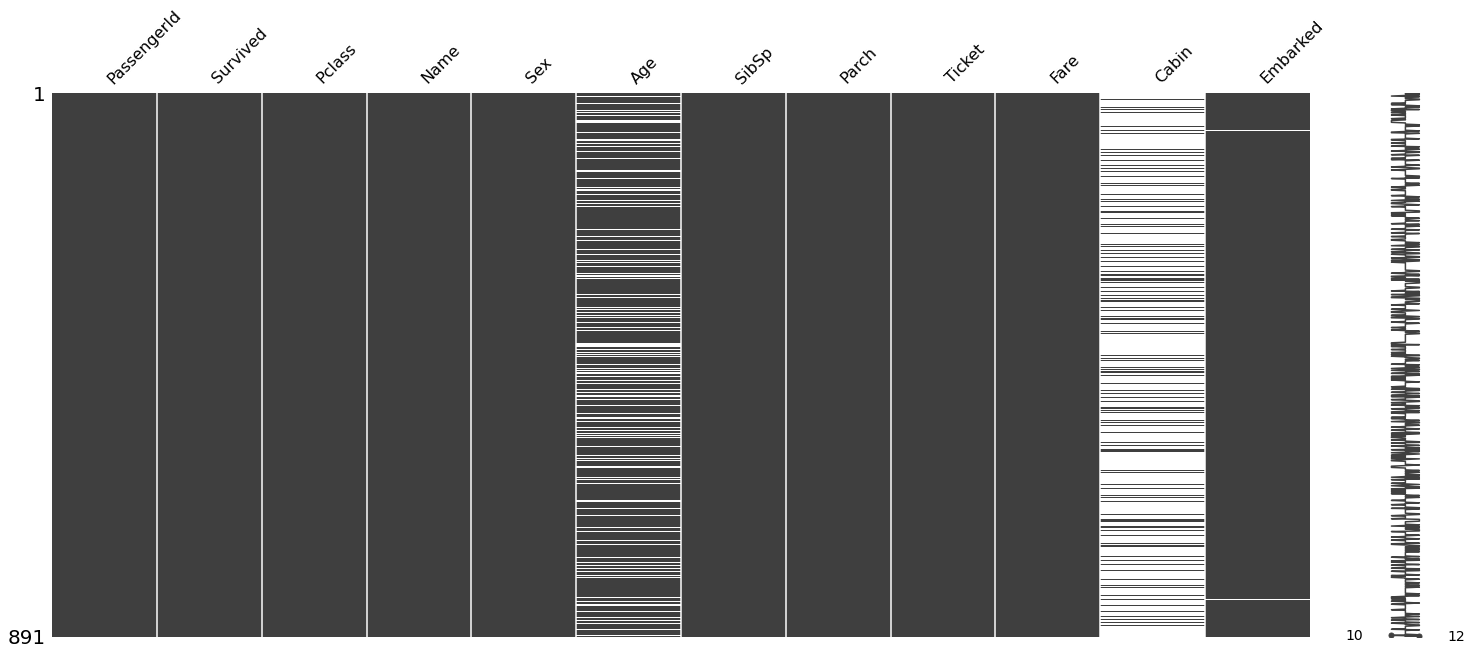

In [157]:
msno.matrix(clean_train)

In [158]:
#all age < 0 are NaN values so going to use data imputation(shown later)
proper_age = clean_train[clean_train['Age']>0]
print(len(clean_train['Age'])-len(proper_age))

177


In [159]:
#dropped Ticket column since 76.5% are unique categorical values
print(len(clean_train['Ticket'].unique())/len(clean_train))
clean_train = clean_train.drop(columns=['Ticket'])

0.7643097643097643


In [160]:
#dropped PassengerID and Name column since all names are unique categorical values
print(len(clean_train['PassengerId'].unique())/len(clean_train))
print(len(clean_train['Name'].unique())/len(clean_train))
clean_train = clean_train.drop(columns=['Name'])
clean_train = clean_train.drop(columns=['PassengerId'])

1.0
1.0


In [161]:
#dropped Cabin column since 77% are NaN values
print(f"Before:\n{clean_train.isnull().sum(axis=0)}")
print(f"\n% of NaN values: {clean_train['Cabin'].isnull().sum(axis=0)/len(clean_train)}")
clean_train = clean_train.drop(columns=['Cabin'])
print(f"\nAfter:\n{clean_train.isnull().sum(axis=0)}")

Before:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

% of NaN values: 0.7710437710437711

After:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


<AxesSubplot:>

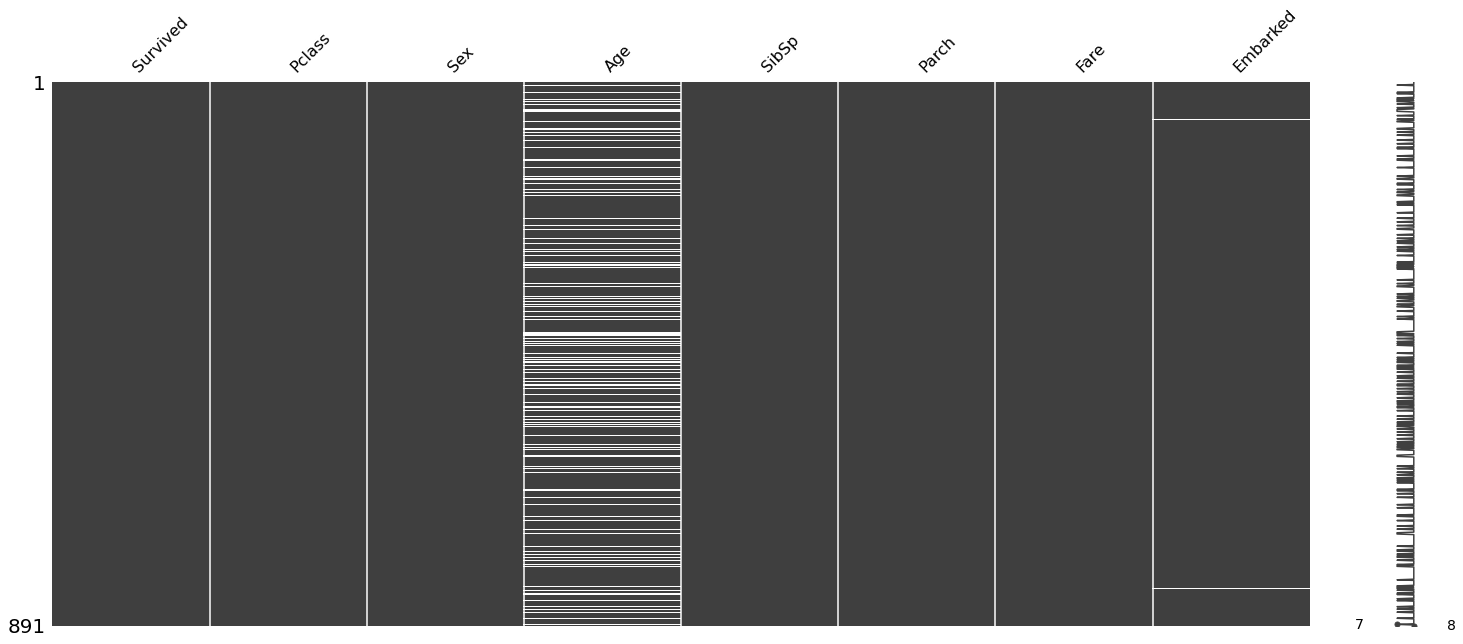

In [162]:
msno.matrix(clean_train)

**Outliers**

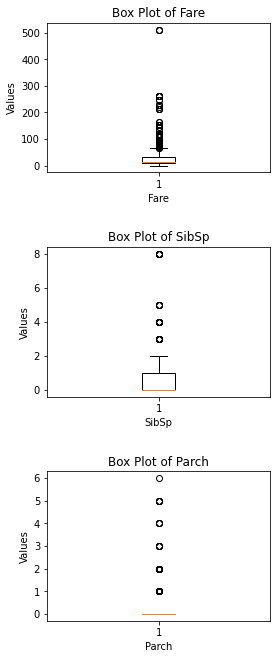

In [163]:
#columns that are skewed based on histogram; creates boxplot for skewed columns
skew = ['Fare','SibSp','Parch']

fig, axes = plt.subplots(nrows=len(skew), figsize=(4,11)) #fig contains subplot, 
                                                                     #an array of subplots

for i, column in enumerate(skew):
    axes[i].boxplot(clean_train[column])
    axes[i].set_title('Box Plot of {}'.format(column))
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Values")


plt.subplots_adjust(hspace=0.5)
#removing the outliers doesn't seem reasonable as there are only a few and the values are reasonable

**Data Imputation**

In [164]:
#Age column
clean_train['Age'].fillna(clean_train['Age'].mode().iloc[0], inplace=True)

Amount of rows that have price as 0: 15 rows


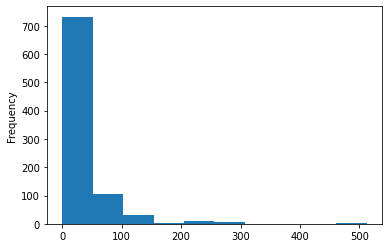

Before:
     Survived  Pclass   Sex   Age  SibSp  Parch  Fare Embarked
179         0       3  male  36.0      0      0   0.0        S
263         0       1  male  40.0      0      0   0.0        S
271         1       3  male  25.0      0      0   0.0        S
277         0       2  male  24.0      0      0   0.0        S
302         0       3  male  19.0      0      0   0.0        S
413         0       2  male  24.0      0      0   0.0        S
466         0       2  male  24.0      0      0   0.0        S
481         0       2  male  24.0      0      0   0.0        S
597         0       3  male  49.0      0      0   0.0        S
633         0       1  male  24.0      0      0   0.0        S
674         0       2  male  24.0      0      0   0.0        S
732         0       2  male  24.0      0      0   0.0        S
806         0       1  male  39.0      0      0   0.0        S
815         0       1  male  24.0      0      0   0.0        S
822         0       1  male  38.0      0      0

In [165]:
#Fare column

print(f"Amount of rows that have price as 0: {len(clean_train['Fare'])-len(clean_train[clean_train['Fare']>0])} rows") 

#Since distribution is heavily skewed to the right, we will find the median of price for each Ticket Class
clean_train['Fare'].plot(kind='hist')
plt.show()

def impute_median(row):
    return clean_train[clean_train['Pclass']==row['Pclass']]['Fare'].median()



print("Before:")
print(clean_train[clean_train['Fare']<=0])
index = clean_train[clean_train['Fare']<=0].index

print("After:")
clean_train['Fare'] = clean_train['Fare'].replace(0, np.nan)
missing_fares = clean_train['Fare'].isnull()
clean_train.loc[missing_fares, 'Fare'] = clean_train[missing_fares].apply(impute_median, axis=1)
print(clean_train.loc[index])

In [166]:
#Embarked column
#print(clean_train[clean_train.isna().any(axis=1)])
clean_train['Embarked'].fillna(clean_train['Embarked'].mode().iloc[0], inplace=True)

In [167]:
clean_train.isnull().sum(axis=0)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

<AxesSubplot:>

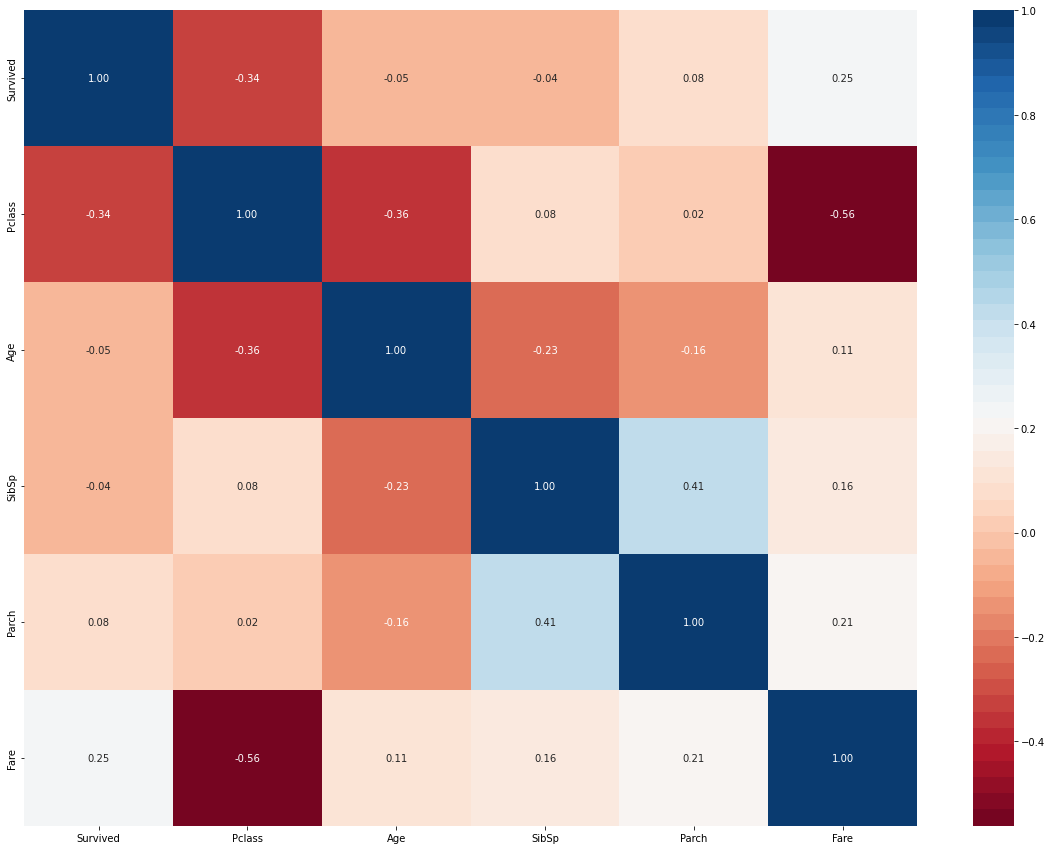

In [168]:
# correlations between the columns
plt.figure(figsize=(20, 15))
sns.heatmap(clean_train.corr(), annot=True, cmap=sns.color_palette('RdBu',50), fmt='.2f')

In [169]:
corr = clean_train.corr().abs()
sort = corr.sort_values(by=['Survived'],ascending=False)
print("Correlation of each variable to Survived:")
sort['Survived']

Correlation of each variable to Survived:


Survived    1.000000
Pclass      0.338481
Fare        0.250383
Parch       0.081629
Age         0.052872
SibSp       0.035322
Name: Survived, dtype: float64

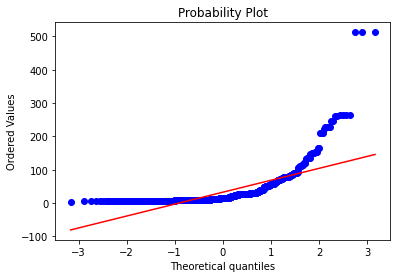

In [170]:
#qqplot
stats.probplot(clean_train['Fare'], dist="norm", plot=pylab)
pylab.show()

0.3172403575315684

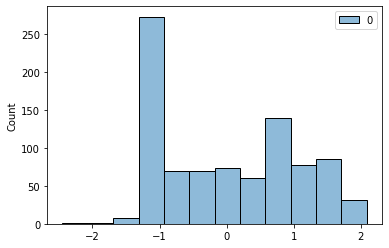

In [171]:
#Transformation decreases correlation so not going to transform
pt = PowerTransformer()
fare_transformed = pt.fit_transform(clean_train['Fare'].values.reshape(-1, 1))
sns.histplot(fare_transformed)

# Compute the correlation between the transformed fare column and survival rate
corr_transformed = pd.Series(fare_transformed.flatten()).corr(clean_train['Survived'])
corr_transformed 

**Duplicates**

In [172]:
duplicated_rows = train.duplicated()
print(f'Number of Duplicated Rows for Train: {duplicated_rows.sum()}')
duplicated_rows = test.duplicated()
print(f'Number of Duplicated Rows for Test: {duplicated_rows.sum()}')

clean_train.shape

Number of Duplicated Rows for Train: 0
Number of Duplicated Rows for Test: 0


(891, 8)

**One-hot Encoding**

In [173]:
#Since only 2/7 columns are categorical, I'm using one-hot encoding since there won't be that much sparsity 
clean_train = pd.get_dummies(data=clean_train, columns=['Sex', 'Embarked'])
clean_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [180]:
clean_train.shape
duplicated_rows = clean_train.duplicated()
print(f'Number of Duplicated Rows: {duplicated_rows.sum()}')

duplicated_df = clean_train[duplicated_rows]

# Print the duplicated DataFrame
print(duplicated_df.sample(10))

Number of Duplicated Rows: 117
     Survived  Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  \
612         1       3  24.0      1      0  15.5000           1         0   
846         0       3  24.0      8      2  69.5500           0         1   
886         0       2  27.0      0      0  13.0000           0         1   
792         0       3  24.0      8      2  69.5500           1         0   
613         0       3  24.0      0      0   7.7500           0         1   
410         0       3  24.0      0      0   7.8958           0         1   
589         0       3  24.0      0      0   8.0500           0         1   
295         0       1  24.0      0      0  27.7208           0         1   
650         0       3  24.0      0      0   7.8958           0         1   
555         0       1  62.0      0      0  26.5500           0         1   

     Embarked_C  Embarked_Q  Embarked_S  age_Pclass_median  \
612           0           1           0               24.0   
846     

**Data Type Conversion**

In [145]:
#converting float to int for all columns that have whole number as float type
for col in clean_train.columns:
    if clean_train[col].dtype == 'float64' and all(clean_train[col].apply(lambda x: x.is_integer())):
        clean_train[col] = clean_train[col].astype(int)
clean_train.dtypes

Survived        int64
Pclass          int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Sex_female      uint8
Sex_male        uint8
Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
dtype: object

# **Feature Engineering**

In [175]:
#categorical column = Pclass
#Num columns to be aggregated = Age(median,std), SibSp(count), Parch(count), Fare(median,std,actual-median)

grouped_train = clean_train.groupby('Pclass')

#Since age and fare distrubutions are skewed, I chose median
clean_train[['age_Pclass_median','fare_Pclass_median']] = grouped_train[['Age', 'Fare']].transform('median')

clean_train[['age_Pclass_std','fare_Pclass_std']] = grouped_train[['Age', 'Fare']].transform('std')

clean_train[['SibSp_count','Parch_count']] = grouped_train[['SibSp', 'Parch']].transform('count') 

#fare-median
clean_train['fare_median_diff'] = clean_train['Fare']-clean_train['fare_Pclass_median']

clean_train.sample(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,age_Pclass_median,fare_Pclass_median,age_Pclass_std,fare_Pclass_std,SibSp_count,Parch_count,fare_median_diff
35,0,1,42.0,1,0,52.0000,0,1,0,0,1,35.0,61.9792,14.590796,77.383157,216,216,-9.9792
856,1,1,45.0,1,1,164.8667,1,0,0,0,1,35.0,61.9792,14.590796,77.383157,216,216,102.8875
280,0,3,65.0,0,0,7.7500,0,1,0,1,0,24.0,8.0500,10.632997,11.723991,491,491,-0.3000
809,1,1,33.0,1,0,53.1000,1,0,0,0,1,35.0,61.9792,14.590796,77.383157,216,216,-8.8792
374,0,3,3.0,3,1,21.0750,1,0,0,0,1,24.0,8.0500,10.632997,11.723991,491,491,13.0250
853,1,1,16.0,0,1,39.4000,1,0,0,0,1,35.0,61.9792,14.590796,77.383157,216,216,-22.5792
398,0,2,23.0,0,0,10.5000,0,1,0,0,1,28.0,15.0229,13.645488,12.916284,184,184,-4.5229
322,1,2,30.0,0,0,12.3500,1,0,0,1,0,28.0,15.0229,13.645488,12.916284,184,184,-2.6729
762,1,3,20.0,0,0,7.2292,0,1,1,0,0,24.0,8.0500,10.632997,11.723991,491,491,-0.8208
813,0,3,6.0,4,2,31.2750,1,0,0,0,1,24.0,8.0500,10.632997,11.723991,491,491,23.2250


# Cleaning test data

In [45]:
clean_test = test.copy()
def clean(clean_test):
    clean_test = clean_test[clean_test['Fare']>0]
    clean_test = clean_test.drop(columns=['Ticket'])
    clean_test = clean_test.drop(columns=['Name'])
    clean_test = clean_test.drop(columns=['Cabin'])
    clean_test['Age'].fillna(clean_test['Age'].mode().iloc[0], inplace=True)
    clean_test['Embarked'].fillna(clean_test['Embarked'].mode().iloc[0], inplace=True)
    
    print(clean_test.iloc[152])
    print()
    ohe = OneHotEncoder(handle_unknown='ignore') 
    test_object = clean_test.select_dtypes('object')
    ohe.fit(test_object)
    codes = ohe.transform(test_object).toarray()
    feature_names = ohe.get_feature_names_out(['Sex', 'Embarked'])
    clean_test = pd.concat([clean_test.select_dtypes(exclude='object'), 
                   pd.DataFrame(codes,columns=feature_names)], axis=1)
    
    
    print(clean_test.iloc[152])
    print()
    #clean_test = clean_test.dropna() can't drop NA because submission requires 418 rows
    nan_mask = clean_test.isna().any(axis=1)

    # use the boolean mask to index the DataFrame and show only the rows with NaN values
    rows_with_nan = clean_test.loc[nan_mask]
    print(rows_with_nan)
    
    
    
    for col in clean_test.columns:
        if clean_test[col].dtype == 'float64' and all(clean_test[col].apply(lambda x: x.is_integer())):
            clean_test[col] = clean_test[col].astype(int)
            
    grouped_test = clean_test.groupby('Pclass')

    clean_test[['age_Pclass_median','fare_Pclass_median']] = grouped_test[['Age', 'Fare']].transform('median')
    clean_test[['age_Pclass_std','fare_Pclass_std']] = grouped_test[['Age', 'Fare']].transform('std')
    clean_test[['SibSp_count','Parch_count']] = grouped_test[['SibSp', 'Parch']].transform('count') 
    clean_test['fare_median_diff'] = clean_test['Fare']-clean_test['fare_Pclass_median']
    return clean_test

clean_test = clean(clean_test)
clean_test.shape

PassengerId       1045
Pclass               3
Sex             female
Age               36.0
SibSp                0
Parch                2
Fare           12.1833
Embarked             S
Name: 153, dtype: object

PassengerId    NaN
Pclass         NaN
Age            NaN
SibSp          NaN
Parch          NaN
Fare           NaN
Sex_female     1.0
Sex_male       0.0
Embarked_C     0.0
Embarked_Q     0.0
Embarked_S     1.0
Name: 152, dtype: float64

     PassengerId  Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  \
152          NaN     NaN   NaN    NaN    NaN      NaN         1.0       0.0   
266          NaN     NaN   NaN    NaN    NaN      NaN         1.0       0.0   
372          NaN     NaN   NaN    NaN    NaN      NaN         1.0       0.0   
415       1307.0     3.0  38.5    0.0    0.0   7.2500         NaN       NaN   
416       1308.0     3.0  21.0    0.0    0.0   8.0500         NaN       NaN   
417       1309.0     3.0  21.0    1.0    1.0  22.3583         NaN       NaN   



(418, 18)

**Duplicates after cleaning**

In [43]:
train_dup_rows = clean_train.duplicated()
test_dup_rows = clean_test.duplicated()

duplicate_rows = clean_test[clean_test.duplicated(keep=False)]
print(duplicate_rows)

#print(test_dup_rows.head())


print(f'Number of Duplicated Rows: {train_dup_rows.sum()}')
print(f'Number of Duplicated Rows: {test_dup_rows.sum()}')
print(f'Shape of train data before dropping Survived col:{clean_train.shape}')
print(f'Shape of train data before dropping Survived col:{clean_test.shape}')

#removing duplicate rows
clean_train = clean_train[~train_dup_rows]


#clean_test.head()

     PassengerId  Pclass  Age  SibSp  Parch  Fare  Sex_female  Sex_male  \
152          NaN     NaN  NaN    NaN    NaN   NaN         1.0       0.0   
266          NaN     NaN  NaN    NaN    NaN   NaN         1.0       0.0   

     Embarked_C  Embarked_Q  Embarked_S  age_Pclass_median  \
152         0.0         0.0         1.0                NaN   
266         0.0         0.0         1.0                NaN   

     fare_Pclass_median  age_Pclass_std  fare_Pclass_std  SibSp_count  \
152                 NaN             NaN              NaN          NaN   
266                 NaN             NaN              NaN          NaN   

     Parch_count  fare_median_diff  
152          NaN               NaN  
266          NaN               NaN  
Number of Duplicated Rows: 0
Number of Duplicated Rows: 1
Shape of train data before dropping Survived col:(766, 18)
Shape of train data before dropping Survived col:(418, 18)


# **Baseline Model**

In [175]:
#log regression; only using Pclass variable as it has highest correlation with Survived

y_train = clean_train['Survived']
x_train = clean_train.drop(columns=['Survived'])

x_test = clean_test.drop(columns=['PassengerId'])
ids = clean_test['PassengerId'].values


sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

baseline = LogisticRegression(class_weight="balanced")
baseline.fit(x_train, y_train)


predictions = logisticRegr.predict(x_test)

#submission file
sub = pd.DataFrame()
sub['PassengerId'] = ids.astype('int')
sub['Survived'] = predictions

subfolder_name = 'Submission'
filename = 'baseline.csv'
filepath = os.path.join(subfolder_name, filename)
sub.to_csv(filepath, index=False, float_format='%.5f')
print("Done!")

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values